In [2]:
from astropy.io import fits

hat = fits.open('hat-p-7_b/hat-p-7_b.fits')
hat.info()

Filename: hat-p-7_b/hat-p-7_b.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   ()      
  1  TCE_1         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  2  TCE_2         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  3  TCE_3         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  4  TCE_4         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  5  TCE_5         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  6  TCE_6         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  7  TCE_7         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  8  Statistics    1 BinTableHDU    221   71427R x 50C   [D, E, J, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


In [51]:
from astropy.table import Table

PRIMARY = hat['PRIMARY']

TCE_1 = hat['TCE_1']
table_tce1 = Table.read(TCE_1) #¿se puede hacer un array de BinTablesHDU?


TCE_2 = hat['TCE_2']
table_tce2 = Table.read(TCE_2) #¿se puede hacer un array de BinTablesHDU?


TCE_3 = hat['TCE_3']
table_tce3 = Table.read(TCE_3) #¿se puede hacer un array de BinTablesHDU?


TCE_4 = hat['TCE_4']
table_tce4 = Table.read(TCE_4) #¿se puede hacer un array de BinTablesHDU?


TCE_5 = hat['TCE_5']
table_tce5 = Table.read(TCE_5) #¿se puede hacer un array de BinTablesHDU?


TCE_6 = hat['TCE_6']
table_tce6 = Table.read(TCE_6) #¿se puede hacer un array de BinTablesHDU?


TCE_7 = hat['TCE_7']
table_tce7 = Table.read(TCE_7)


TIME,TIMECORR,CADENCENO,PHASE,LC_INIT,LC_INIT_ERR,LC_WHITE,LC_DETREND,MODEL_INIT,MODEL_WHITE
BJD - 2454833,d,,days,dimensionless,dimensionless,dimensionless,dimensionless,dimensionless,dimensionless
float64,float32,int32,float32,float32,float32,float32,float32,float32,float32
1.3151205e+02,-1.059829e-03,1105,3.5322042e+00,nan,nan,nan,nan,0.0000000e+00,4.5700003e-03
1.3153249e+02,-1.060562e-03,1106,3.5526385e+00,nan,nan,nan,nan,0.0000000e+00,4.5751622e-03
1.3155292e+02,-1.061294e-03,1107,3.5730729e+00,nan,nan,nan,nan,0.0000000e+00,4.5802849e-03
1.3157336e+02,-1.062026e-03,1108,3.5935071e+00,nan,nan,nan,nan,0.0000000e+00,4.5853681e-03
1.3159379e+02,-1.062758e-03,1109,3.6139414e+00,nan,nan,nan,nan,0.0000000e+00,4.5904121e-03
1.3161423e+02,-1.063491e-03,1110,3.6343758e+00,nan,nan,nan,nan,0.0000000e+00,4.5954166e-03
1.3163466e+02,-1.064223e-03,1111,3.6548102e+00,nan,nan,nan,nan,0.0000000e+00,4.6003810e-03
1.3165509e+02,-1.064955e-03,1112,3.6752443e+00,nan,nan,nan,nan,0.0000000e+00,4.6053058e-03


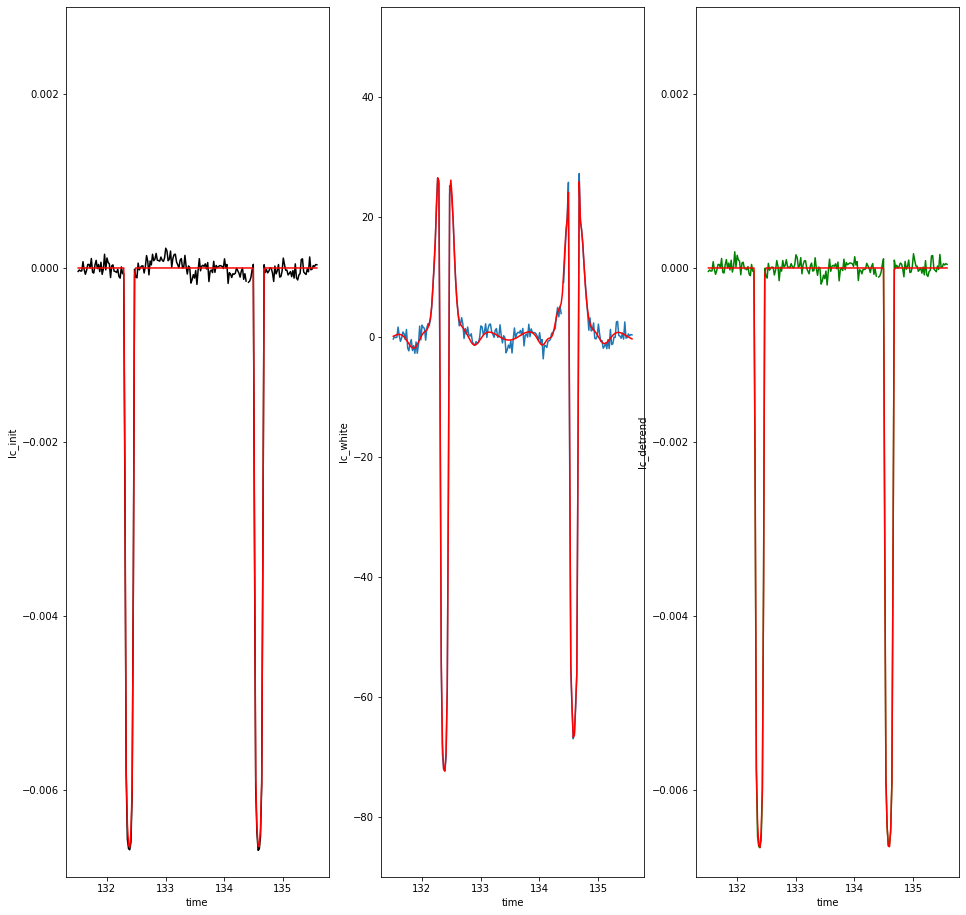

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline


tce1_time = table_tce1['TIME'].data
# tce1_timecorr = table_tce1['TIMECORR'].data
# tce1_cadenceno = table_tce1['CADENCENO'].data
# tce1_phase = table_tce1['PHASE'].data
tce1_lc_init = table_tce1['LC_INIT'].data
tce1_lc_init_err = table_tce1['LC_INIT_ERR'].data
tce1_lc_white = table_tce1['LC_WHITE'].data
tce1_lc_detrend = table_tce1['LC_DETREND'].data
tce1_model_init = table_tce1['MODEL_INIT'].data
tce1_model_white = table_tce1['MODEL_WHITE'].data

fig, ax = plt.subplots(1,3, figsize=(16,16))



ax[0].plot(tce1_time[0:200], tce1_lc_init[0:200], '-k')
ax[0].plot(tce1_time[0:200], tce1_model_init[0:200], '-r')
ax[0].set_ylim(-0.007,0.003)
ax[0].set_xlabel('time')
ax[0].set_ylabel('lc_init')

ax[1].plot(tce1_time[0:200], tce1_lc_white[0:200])
ax[1].plot(tce1_time[0:200], tce1_model_white[0:200], '-r')
ax[1].set_ylim(-90, 55)
ax[1].set_xlabel('time')
ax[1].set_ylabel('lc_white')

ax[2].plot(tce1_time[0:200], tce1_lc_detrend[0:200], '-g')
ax[2].plot(tce1_time[0:200], tce1_model_init[0:200], '-r')
ax[2].set_ylim(-0.007,0.003)
ax[2].set_xlabel('time')
ax[2].set_ylabel('lc_detrend')


plt.show()


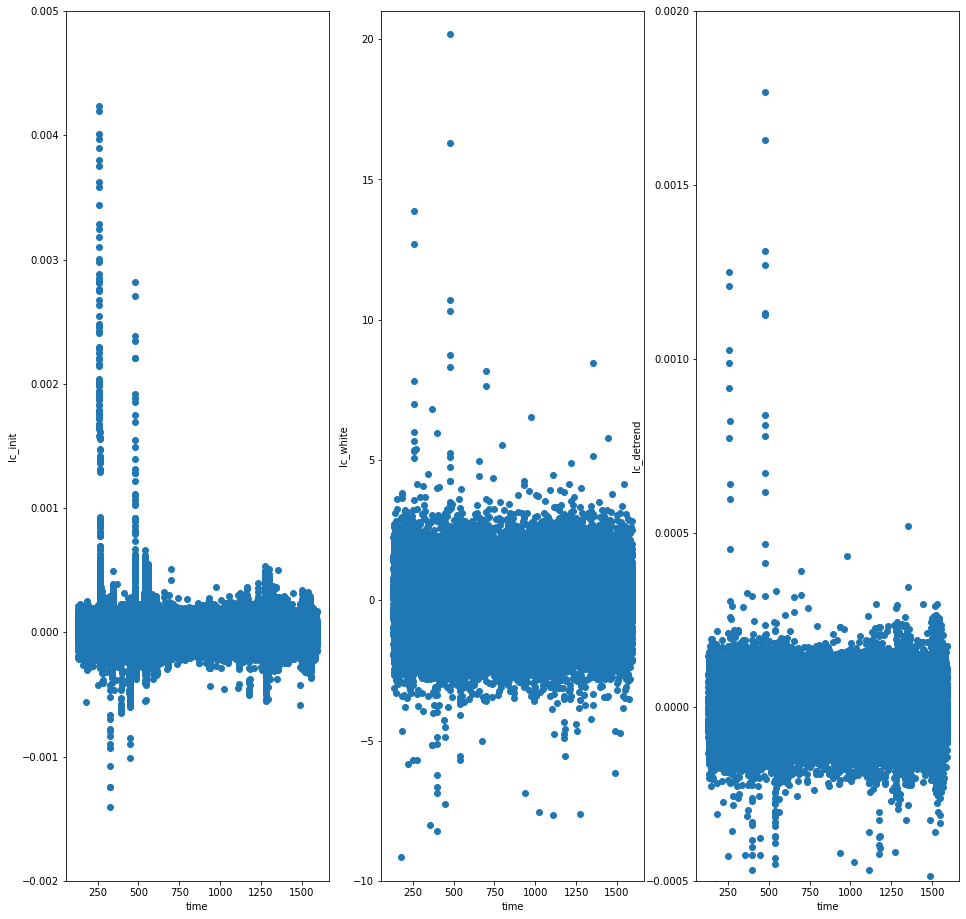

In [48]:
tce2_time = table_tce1['TIME'].data
# tce2_timecorr = table_tce2['TIMECORR'].data
# tce2_cadenceno = table_tce2['CADENCENO'].data
# tce2_phase = table_tce2['PHASE'].data
tce2_lc_init = table_tce2['LC_INIT'].data
tce2_lc_init_err = table_tce2['LC_INIT_ERR'].data
tce2_lc_white = table_tce2['LC_WHITE'].data
tce2_lc_detrend = table_tce2['LC_DETREND'].data
# tce2_model_init = table_tce2['MODEL_INIT'].data
# tce2_model_white = table_tce2['MODEL_WHITE'].data

fig, ax = plt.subplots(1,3, figsize=(16,16))



ax[0].scatter(tce2_time, tce2_lc_init)
ax[0].set_ylim(-0.002,0.005)
ax[0].set_xlabel('time')
ax[0].set_ylabel('lc_init')

ax[1].scatter(tce2_time, tce2_lc_white)
ax[1].set_ylim(-10, 21)
ax[1].set_xlabel('time')
ax[1].set_ylabel('lc_white')

ax[2].scatter(tce2_time, tce2_lc_detrend)
ax[2].set_ylim(-0.0005,0.002)
ax[2].set_xlabel('time')
ax[2].set_ylabel('lc_detrend')


plt.show()

---
## References


1. K. Mandel and E. Agol. *Analytic Lightcurves for Planetary Transit Searches*. [astro-ph:0210099](https://arxiv.org/pdf/astro-ph/0210099.pdf).
2. S. E. Thompson 2016, Data Validation Time Series
File: Description of the File Format and Content, KSCI-19079-001.